# 04. PyTroch Custom Datasets

## Importing PyTorch and setting up PyTorch agnostic code

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import requests
import zipfile
from pathlib import Path
import pathlib
from typing import Tuple, Dict, List
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
import pandas as pd
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
try:
  import wandb
except:
  !pip install wandb
  import wandb
from torchinfo import summary

# PyTorch 1.10.0
torch.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


'2.3.0+cu121'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get Data

Our dataset is a subset of the Food101 dataset.

Our dataset starts with 3 classes of food and only 10% of the images (75 Training, 25 Testing Images).

When starting out ML Projects it's important to try things on a small scale and then increase the scale when necessary.

In [ ]:
# Setup path to a datafolder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the Image Folder doesn't exist don't download
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, create one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download Data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading Data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping Data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, create one...
Unzipping Data


## Becoming one with the data

In [ ]:
def walk_through_dir(dir_path):
  """Walks through Dir"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} dir and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 dir and 0 images in 'data/pizza_steak_sushi'.
There are 3 dir and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 dir and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 dir and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 dir and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 dir and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 dir and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 dir and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 dir and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visulizing an image

Let's write some code to:

1. Get all the image Paths
2. Pick a random Image Path with `random.choise()`
3. Get the Image class name `pathlib.Path.parents.stem`
4. Since we're working with images, let's open the image with Python Pillow
5. We'll then show the image and print metadata

data/pizza_steak_sushi/test/sushi/1600999.jpg
sushi
Random Image Path: data/pizza_steak_sushi/test/sushi/1600999.jpg
Image class: sushi
Image Height: 484
Image Width: 512


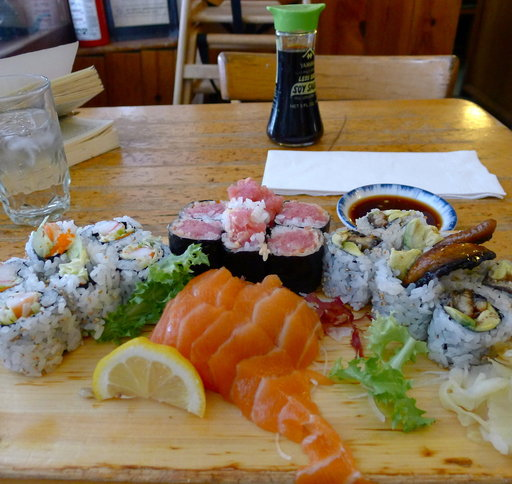

In [ ]:
# Set seed
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick an random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get Image Class from the Path name (The image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print Metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

data/pizza_steak_sushi/test/steak/1868005.jpg
steak


(-0.5, 511.5, 483.5, -0.5)

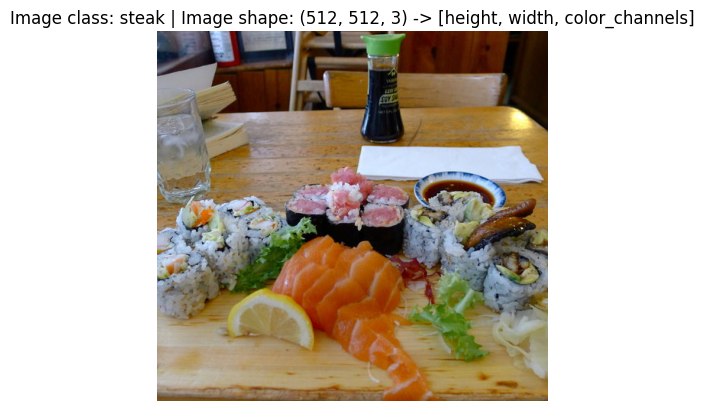

In [ ]:
# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick an random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get Image Class from the Path name (The image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# Trun Image into Array
img_asarray = np.asarray(Image.open(random_image_path))

# Plot Image with matplotlib
plt.imshow(img)
plt.title(f"Image class: {image_class} | Image shape: {img_asarray.shape} -> [height, width, color_channels]")
plt.axis(False)

## Transforming Data

Before we can use our image data with PyTorch:
1. Turn your target data into Tensors (In our case, numerical representation of our images.)
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset`and `Dataloader`

### Transforming Data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),

    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # Turn the image into a Torch Tensor
    transforms.ToTensor()

])

In [ ]:
data_transform(img)

tensor([[[0.1686, 0.1882, 0.2000,  ..., 0.3569, 0.3059, 0.2549],
         [0.1569, 0.1765, 0.1961,  ..., 0.2980, 0.2431, 0.2157],
         [0.1412, 0.1608, 0.1843,  ..., 0.2549, 0.2196, 0.2471],
         ...,
         [0.6157, 0.6392, 0.6353,  ..., 0.6941, 0.6824, 0.6745],
         [0.6353, 0.6431, 0.6235,  ..., 0.5765, 0.5725, 0.5608],
         [0.5216, 0.5373, 0.5412,  ..., 0.4706, 0.4667, 0.4588]],

        [[0.0706, 0.0941, 0.1020,  ..., 0.3294, 0.3137, 0.3137],
         [0.0627, 0.0824, 0.0980,  ..., 0.2863, 0.2824, 0.2824],
         [0.0549, 0.0706, 0.0902,  ..., 0.2549, 0.2745, 0.3216],
         ...,
         [0.4824, 0.5176, 0.5255,  ..., 0.6314, 0.6275, 0.6275],
         [0.4824, 0.4980, 0.4824,  ..., 0.5020, 0.5098, 0.4980],
         [0.3882, 0.4196, 0.4118,  ..., 0.3608, 0.3529, 0.3412]],

        [[0.0039, 0.0039, 0.0078,  ..., 0.3686, 0.3725, 0.4000],
         [0.0039, 0.0039, 0.0039,  ..., 0.3216, 0.3490, 0.3804],
         [0.0039, 0.0078, 0.0039,  ..., 0.2902, 0.3294, 0.

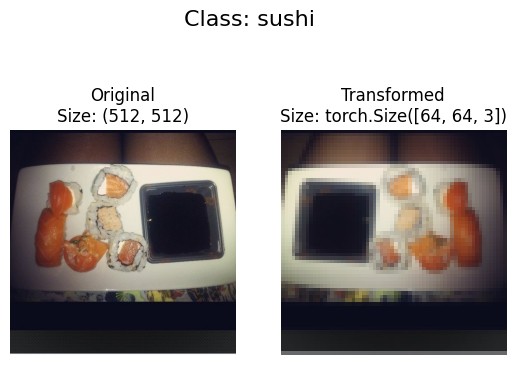

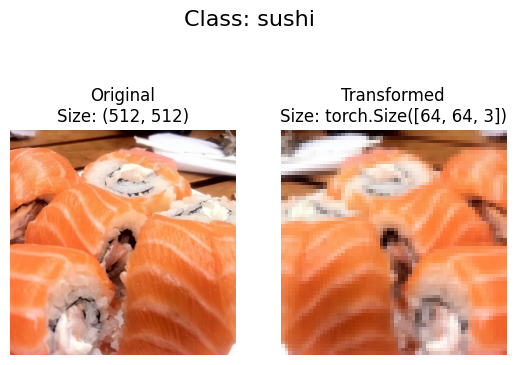

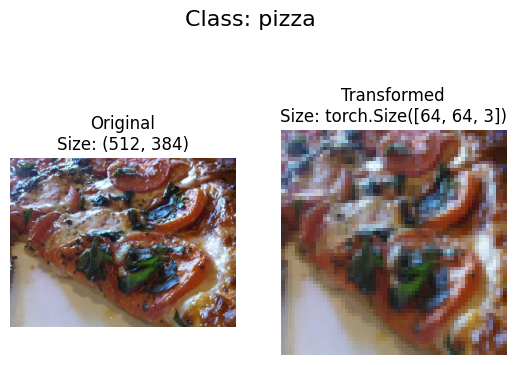

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images and loads/transforms them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # We will need to change shape for matplotlib -> (C, H, W) => (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform, 3)

## Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image Permute shape: torch.Size([64, 64, 3]) -> [H, W, C]


Text(0.5, 1.0, 'pizza')

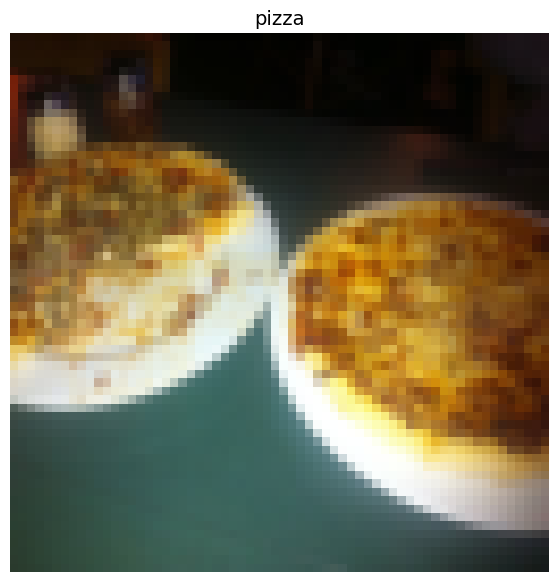

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image Permute shape: {img_permute.shape} -> [H, W, C]")

# Plot the Image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### Turn loaded images into DataLoaders

A Dataloader is going to help us turning our Datasets into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
# Turn train and test datasets into DataLoader's

BATCH_SIZE = 32


train_dataloader = DataLoader(dataset= train_data,
                              batch_size= BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle= True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle= False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b4f1224f850>,
 <torch.utils.data.dataloader.DataLoader at 0x7b4f1224fe80>)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


## Option 2: Loading image data with a custom `Dataset

1. Want to be able to load images from a File
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes dictornary from the Dataset

Pros:
* Create a Dataset out of anything
* Not limited to PyTorch pre-build Dataset functions

Cons:
* Even if you could create a `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom `Dataset ofteb results in us writing more code, which could be prone to errors or performens issues


In [ ]:
# Instance from torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a Helper Function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target dir (ideally the dir is standard image classification format)
2. Raise an error if the class names aren't found (if this happens there might be something wrong with the dir structure)
3. Turn the class names into a dict and a list and return them

In [ ]:
# Setup path for target dir
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory
  """
  # 1. Get Class names by scaning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Rais an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure")

  # 3. Create a dict of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom Dataset we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the dir we'd like to get data from) as well as a transform if we'd like to transform our data
3. Create several attributes
  * paths - path of our image
  * transform - the transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [ ]:
# Write a custom dataset class

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Init our custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create Classes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # Create a Function to Load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # Overwrite __getitem__() to get a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Return one sample of data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Excepcts path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # Return
    else:
      return img, class_idx # Return untransformed image and label

In [ ]:
# Create a Transform
train_transforms = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.ToTensor()
])

In [ ]:
# Test out image Folder custom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7b4f1224cb20>,
 <__main__.ImageFolderCustom at 0x7b4f1224db10>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for a Quality between original Folder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting our of hand, let's cap the number of images to see at 10.
3. Set a random seed
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample images and then plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [ ]:
# Create a function to take in a Dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is to high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be higher than 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random images (indexes) and plot them
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust Tensor dimesions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [c, h, w] -> [w, h, c]

    # Plot adjustet samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axes = False
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)



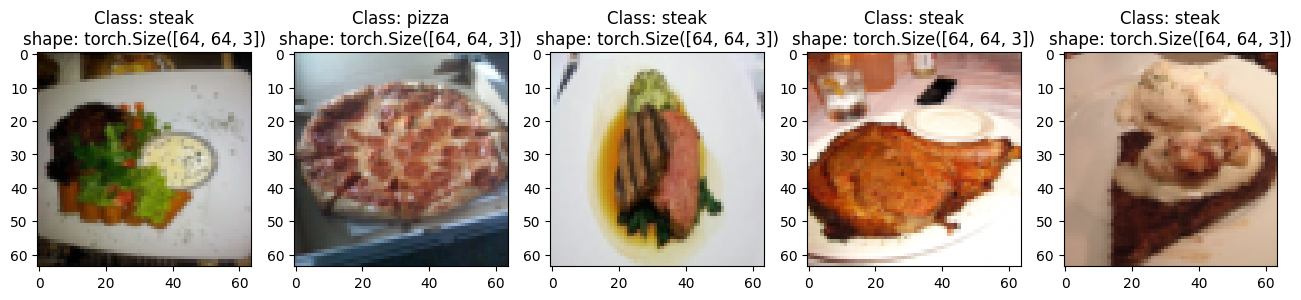

In [ ]:
display_random_images(dataset = train_data,
                          classes = class_names,
                          n = 5,
                          display_shape = True,
                          seed = None)

For display, purposes, n shouldn't be higher than 10


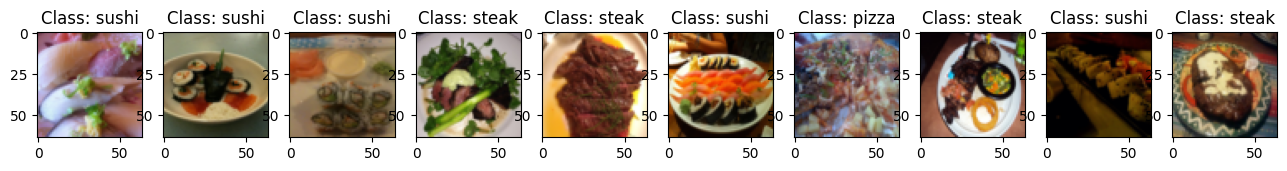

In [ ]:
display_random_images(dataset = train_data_custom,
                          classes = class_names,
                          n = 20,
                          display_shape = True,
                          seed = None)

### Trun Loaded images into DataLoaders

In [ ]:
BATCH_SIZE = 32


train_dataloader_custom = DataLoader(dataset= train_data_custom,
                              batch_size= BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle= True)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                              batch_size = BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle= False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7b4f1243b3a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b4f11418160>)

In [ ]:
# Get image and Label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Other Forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to you training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Get all Image Paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1849463.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2881783.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/735441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1787505.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3142674.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3857508.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/239025.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2163079.jpg')]

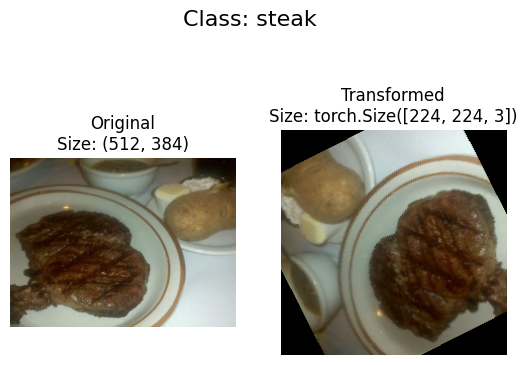

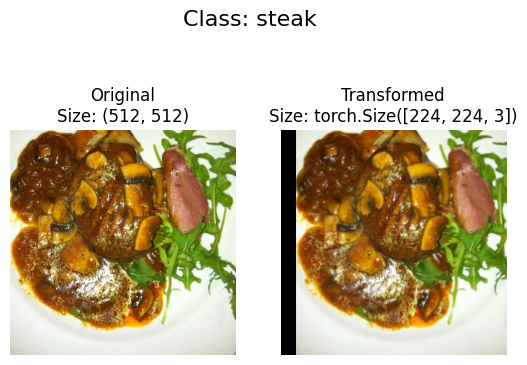

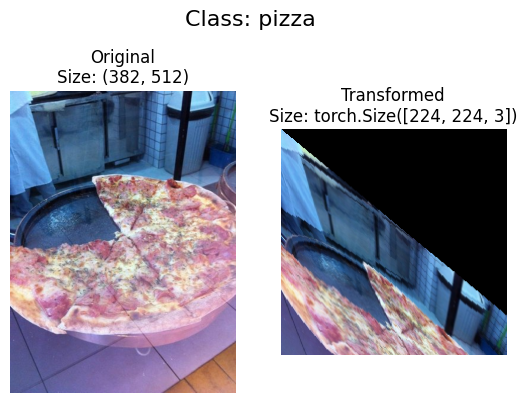

In [ ]:
# Plot rand images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
)

## Model 0: TinyVGG without data augmentation

### Creating transforms and loading data for Model 0

In [ ]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn the Dataset into Dataloader

# Setup Batch Size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### Replicating TinyVGG from Scratch

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(input_shape,
                  hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_units,
                  hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # Default is the same as Kernel Size
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units,
                  hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_units,
                  hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.block_2(self.block_1(x)))

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # Number of Color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a Forward pass on a Single Image

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a Forward pass
model_0(image_batch).to(device)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `Torchinfo` to get an idea of the shapes going through the model

In [ ]:
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Create train and test loop function

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
def train_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device = device):

  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)


  return train_loss, train_acc



In [ ]:
def test_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                device: torch.device = device):

  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      test_loss += loss_fn(y_pred, y).item()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)

  test_loss /= len(data_loader)
  test_acc /= len(data_loader)

  return test_loss, test_acc



In [ ]:
def train(epochs: int,
               model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}


  for epoch in tqdm(range(epochs)):
    if epoch % 1 == 0:
      print(f"Epoch: {epoch}\n---------")

    train_loss, train_acc = train_model(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)

    test_loss, test_acc = test_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn)

    if epoch % 1 == 0:
      print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}")
      print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.5f}\n")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


model_0 = TinyVGG(input_shape=3, # Number of Color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

start_time = timer()

model_0_results = train(epochs= 5,
           model= model_0,
           train_dataloader= train_dataloader_simple,
           test_dataloader= test_dataloader_simple,
           loss_fn= nn.CrossEntropyLoss(),
           optimizer= torch.optim.Adam(params=model_0.parameters(), lr=0.001))

end_time = timer()
print(f"Total Time: {end_time-start_time:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 1.10632 | Train Accuracy: 0.30469
Test Loss: 1.09832 | Test Accuracy: 0.30114

Epoch: 1
---------
Train Loss: 1.09981 | Train Accuracy: 0.32812
Test Loss: 1.06969 | Test Accuracy: 0.54167

Epoch: 2
---------
Train Loss: 1.08685 | Train Accuracy: 0.48828
Test Loss: 1.08076 | Test Accuracy: 0.49242

Epoch: 3
---------
Train Loss: 1.08423 | Train Accuracy: 0.39844
Test Loss: 1.06083 | Test Accuracy: 0.58333

Epoch: 4
---------
Train Loss: 1.06622 | Train Accuracy: 0.41406
Test Loss: 1.06540 | Test Accuracy: 0.56439

Total Time: 15.316


In [ ]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

In [ ]:
def plotCurves(results: Dict[str, List[float]]):
  train_loss = results["train_loss"]
  train_acc = results["train_acc"]

  test_loss = results["test_loss"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label="Train Loss")
  plt.plot(epochs, test_loss, label="Test Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label="Train Accuracy")
  plt.plot(epochs, test_acc, label="Test Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

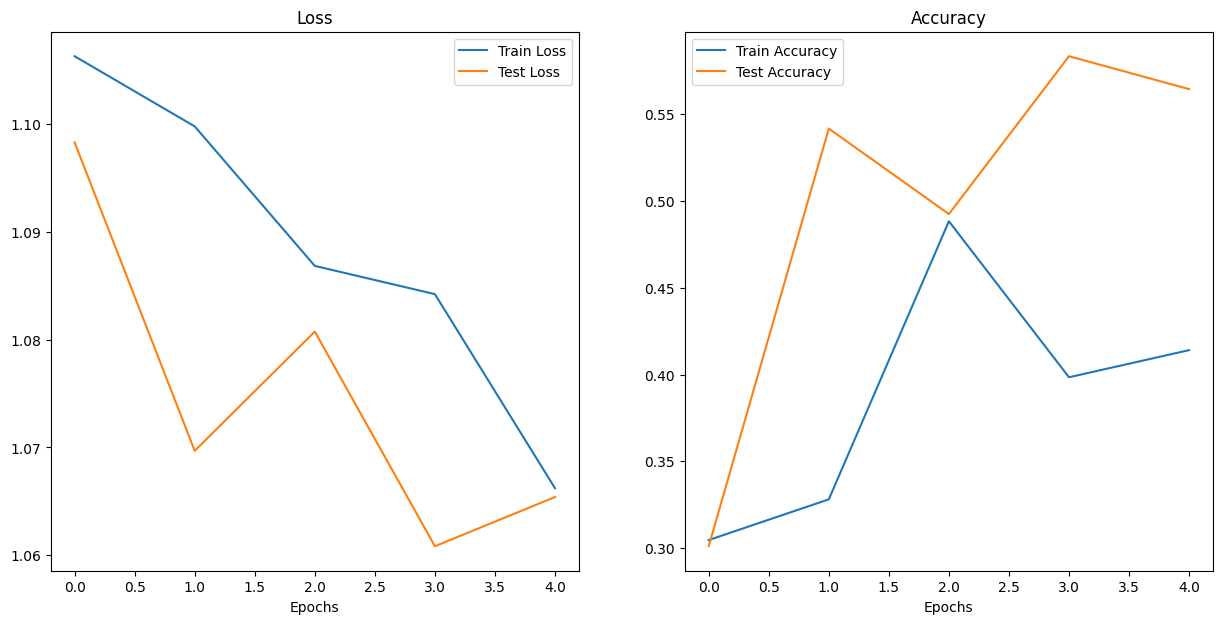

In [ ]:
plotCurves(model_0_results)

## What should an ideal loss curve look like?

## Model 1: TinyVGG with Data Augumentation

Now let's try another modeling experience this time use the same model as before with some data augumentation

### Create transform with data augumentation

In [ ]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### Create train and test `Dataset`'s and `Dataloader`'s with Data Augmentation

In [ ]:
# Turn image Folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial,
                                            )

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_simple,
                                            )

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

### Construct and train model 1

In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# Extract convolutional layers and their weights
conv_weights = []  # List to store convolutional layer weights
conv_layers = []  # List to store convolutional layers
total_conv_layers = 0  # Counter for total convolutional layers

In [ ]:
# Iterate through model's children modules
for module in model_1.children():
    if isinstance(module, nn.Sequential):
        for layer in module.children():
            if isinstance(layer, nn.Conv2d):
                total_conv_layers += 1
                conv_weights.append(layer.weight)
                conv_layers.append(layer)

print(f"Total convolution layers: {total_conv_layers}")

Total convolution layers: 4


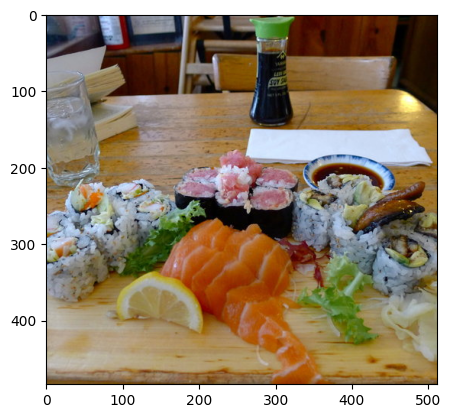

In [ ]:
# Load the image
input_image = Image.open(str('/content/data/pizza_steak_sushi/test/sushi/1600999.jpg')) # add your image path
plt.imshow(input_image)
plt.show()

In [ ]:
input_image = test_transform_simple(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension

# Extract feature maps
feature_maps = []  # List to store feature maps
layer_names = []  # List to store layer names
for layer in conv_layers:
    input_image = layer(input_image)
    feature_maps.append(input_image)
    layer_names.append(str(layer))

In [ ]:
# Display feature maps shapes
print("\nFeature maps shape")
for feature_map in feature_maps:
    print(feature_map.shape)

# Process and visualize feature maps
processed_feature_maps = []  # List to store processed feature maps
for feature_map in feature_maps:
    feature_map = feature_map.squeeze(0)  # Remove the batch dimension
    mean_feature_map = torch.sum(feature_map, 0) / feature_map.shape[0]  # Compute mean across channels
    processed_feature_maps.append(mean_feature_map.data.cpu().numpy())


Feature maps shape
torch.Size([1, 10, 62, 62])
torch.Size([1, 10, 60, 60])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 56, 56])



 Processed feature maps shape
(62, 62)
(60, 60)
(58, 58)
(56, 56)


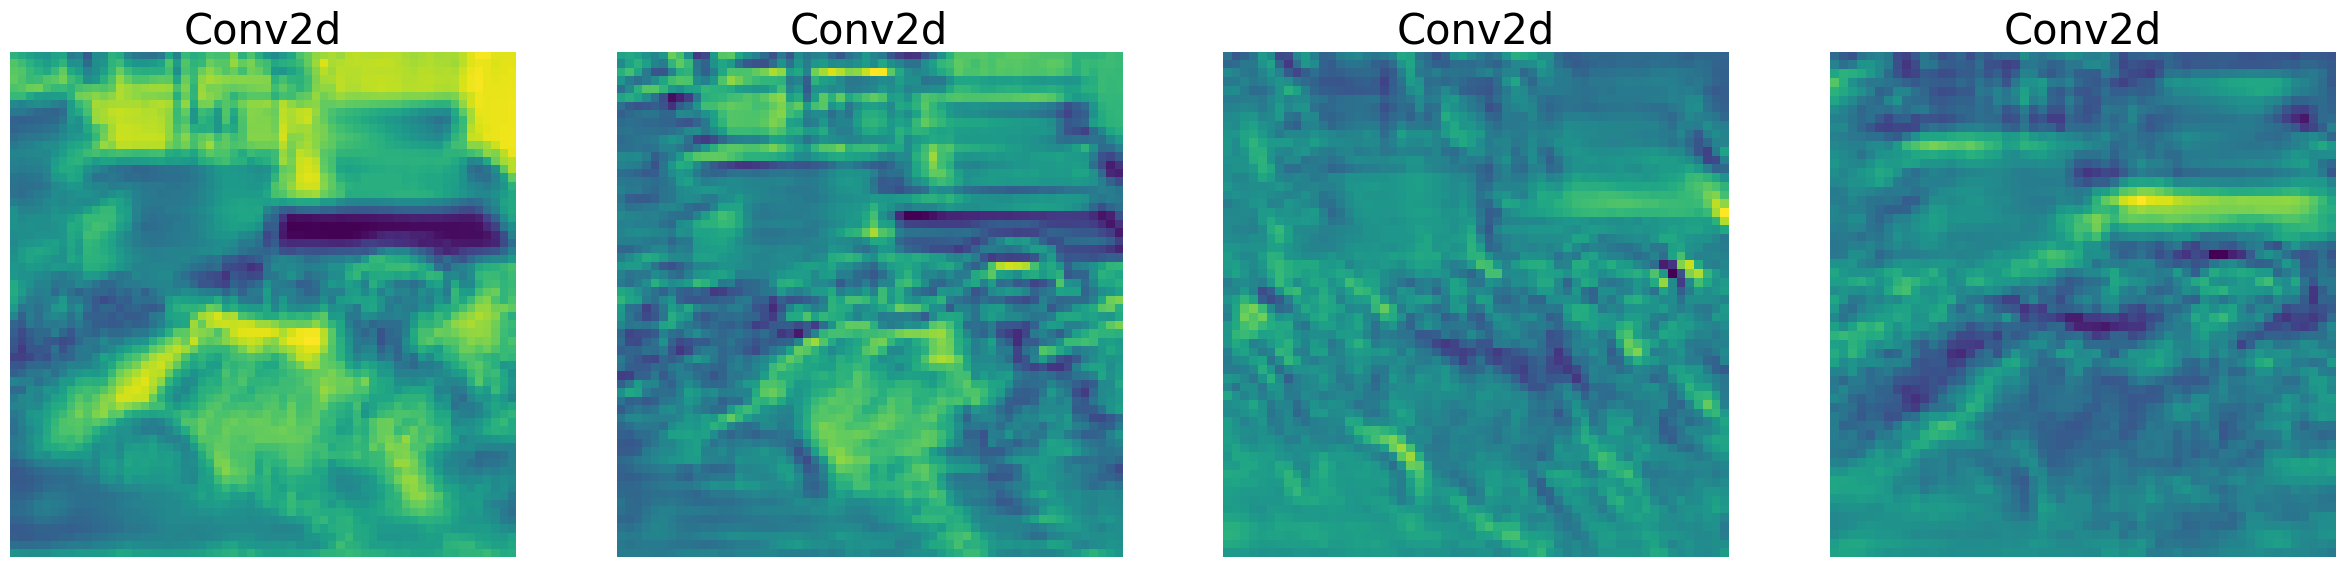

In [ ]:
# Display processed feature maps shapes
print("\n Processed feature maps shape")
for fm in processed_feature_maps:
    print(fm.shape)

# Plot the feature maps
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed_feature_maps)):
    ax = fig.add_subplot(5, 4, i + 1)
    ax.imshow(processed_feature_maps[i])
    ax.axis("off")
    ax.set_title(layer_names[i].split('(')[0], fontsize=30)

In [ ]:
# Set Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set Epochs
EPOCHS = 5

# Set Loss FN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start timer
start_time = timer()

# Train Model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)

# End timer
end_time = timer()

print(f"Total Training Time= {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 1.10491 | Train Accuracy: 0.25000
Test Loss: 1.10193 | Test Accuracy: 0.26042

Epoch: 1
---------
Train Loss: 1.08069 | Train Accuracy: 0.42578
Test Loss: 1.12606 | Test Accuracy: 0.26042

Epoch: 2
---------
Train Loss: 1.07117 | Train Accuracy: 0.42578
Test Loss: 1.15927 | Test Accuracy: 0.26042

Epoch: 3
---------
Train Loss: 1.12531 | Train Accuracy: 0.30469
Test Loss: 1.15807 | Test Accuracy: 0.26042

Epoch: 4
---------
Train Loss: 1.08653 | Train Accuracy: 0.42578
Test Loss: 1.15543 | Test Accuracy: 0.33333

Total Training Time= 12.006 seconds


### Plot loss curves of model 1

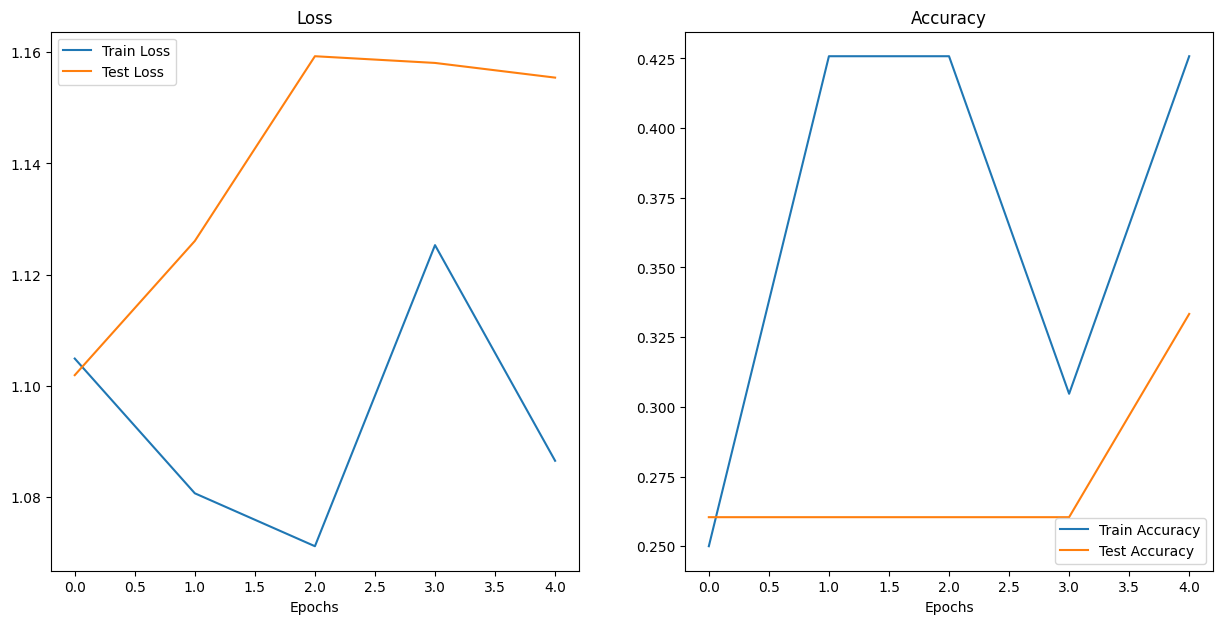

In [ ]:
plotCurves(model_1_results)

## Compare model results

In [ ]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099806   0.328125   1.069690  0.541667
2    1.086854   0.488281   1.080757  0.492424
3    1.084233   0.398438   1.060832  0.583333
4    1.066216   0.414062   1.065396  0.564394

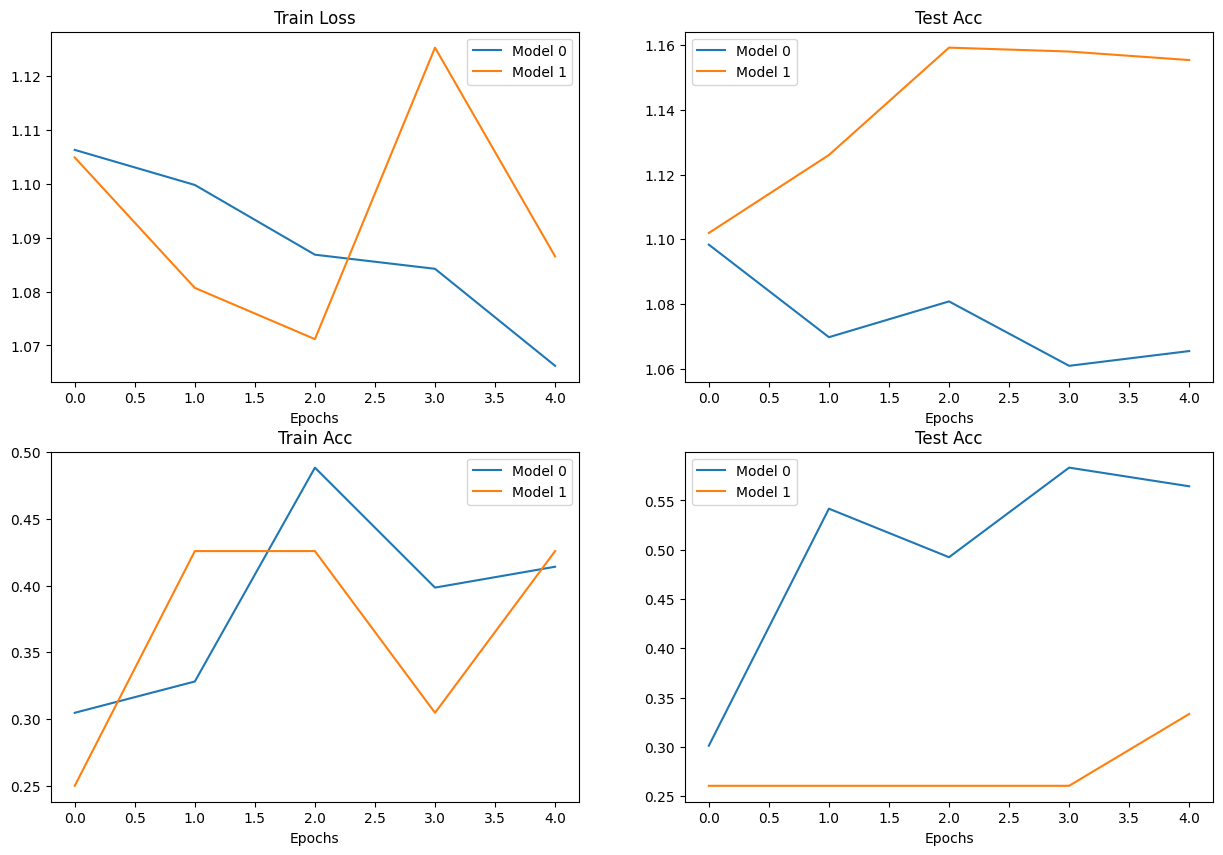

In [ ]:
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

# Plot Train Loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"],label="Model 0")
plt.plot(epochs, model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Test Loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"],label="Model 0")
plt.plot(epochs, model_1_df["test_loss"],label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot Train Acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"],label="Model 0")
plt.plot(epochs, model_1_df["train_acc"],label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Test Acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"],label="Model 0")
plt.plot(epochs, model_1_df["test_acc"],label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [ ]:
activations = {}
model_1
model_1.block_1[0].register_forward_hook(get_activation('conv1'))

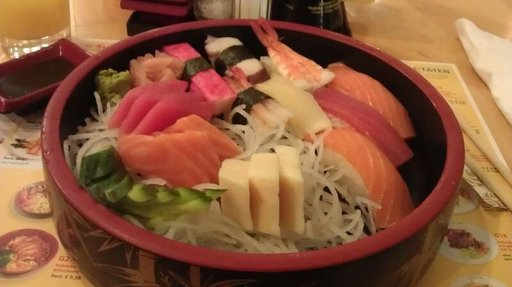

In [ ]:
# Set seed
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick an random image path
random_image_path = random.choice(image_path_list)

# 3. Get Image Class from the Path name (The image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print Metadata
img

Total convolution layers: 4


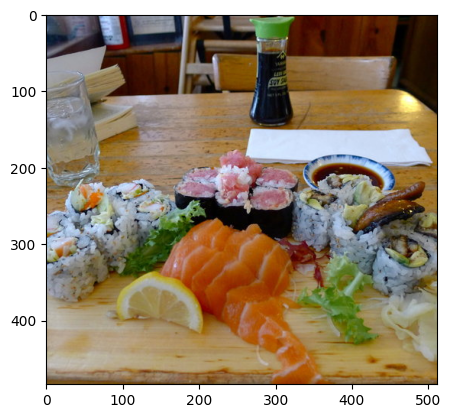


Feature maps shape
torch.Size([1, 10, 62, 62])
torch.Size([1, 10, 60, 60])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 56, 56])

 Processed feature maps shape
(62, 62)
(60, 60)
(58, 58)
(56, 56)


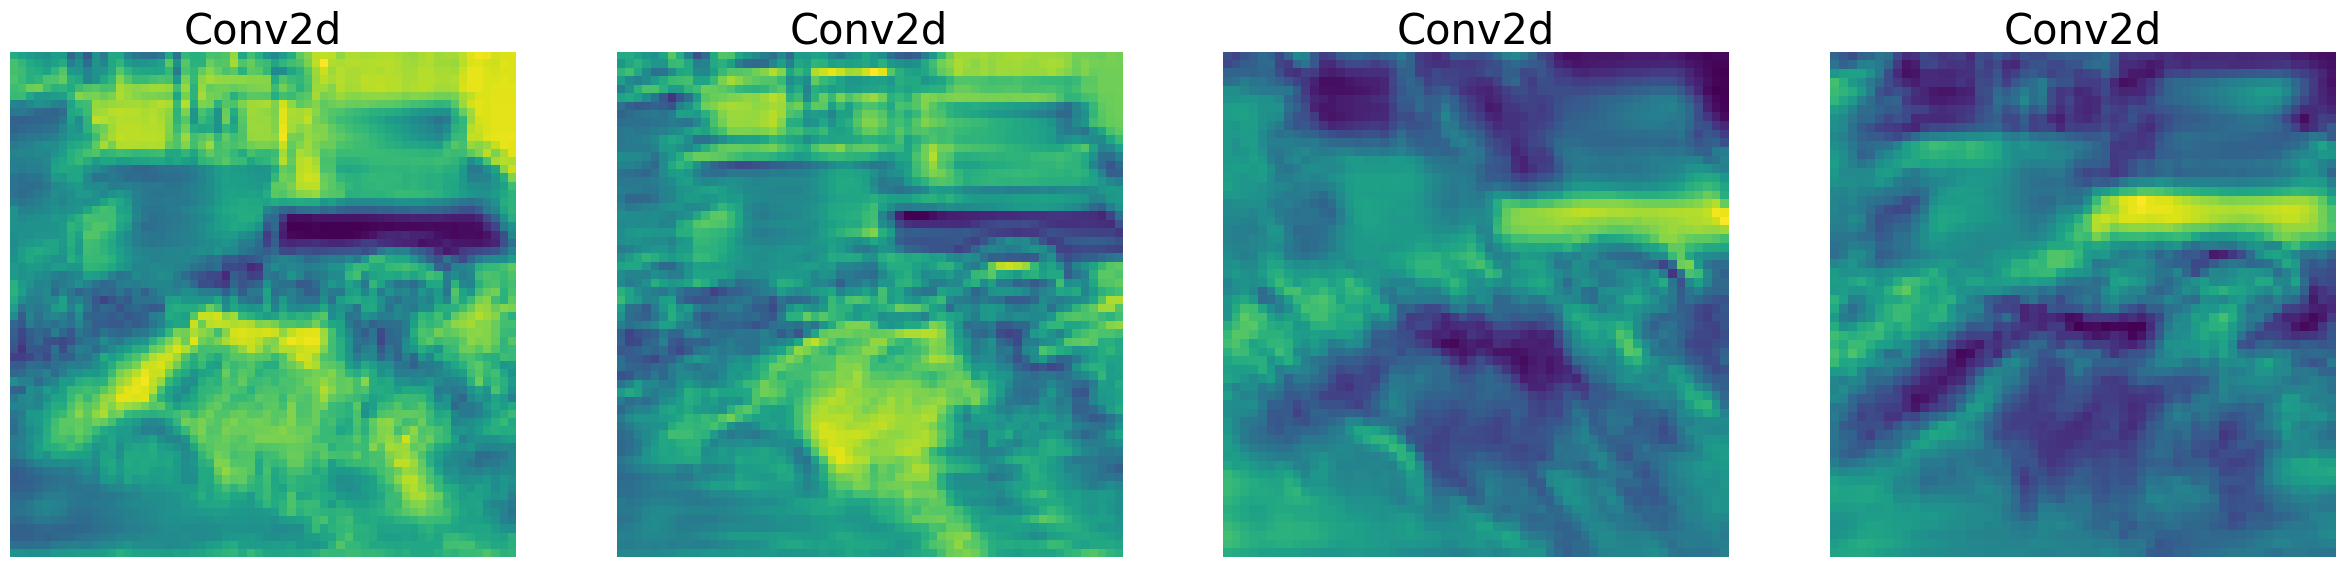

In [ ]:
wandb.login()

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Test_Food_Project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "pizza_steak_sushi",
    "epochs": 5,
    }
)